### Embryo zebrafish development data: https://pubmed.ncbi.nlm.nih.gov/37468546/

In [27]:
import sys
import os
sys.path.append(os.path.abspath("../../src/utils"))
from preprocess import *  
from plotting import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


data_dir = "../../data/embryo/raw/"
plot_dir = "../../data/embryo/plots/"
os.makedirs(plot_dir, exist_ok=True)

#### Load ATAC data and metadata

In [2]:
atac_data_path = os.path.join(data_dir, "atac_peak_matrix_complete_sparse.csv")
atac_data_df = pd.read_csv(atac_data_path)

meta_path = os.path.join(data_dir, "atac_all.metaData.txt")
atac_metadata_df = pd.read_csv(meta_path, index_col=0)


Map ATAC Cells: Assign each cell a pseudobulk, developmental stage + cell type using the authors' celltype assignment

In [3]:
atac_metadata_df = (
    atac_metadata_df
    [['celltype', 'predictedCell', 'predictedGroup']]
    .rename(columns={
        'celltype': 'atac_cell_type',
        'predictedCell': 'rna_matching_cell',
        'predictedGroup': 'rna_cell_type'
    })
    .reset_index(names="atac_cell")
)

def extract_stage(cell_id, delimiter='h', pos=0):
    return str(cell_id).split(delimiter)[pos].replace('h', '')

atac_metadata_df = atac_metadata_df.assign(
    rna_stage=lambda df: df['rna_matching_cell'].apply(extract_stage, args=('h', 0)),
    atac_stage=lambda df: df['atac_cell'].apply(extract_stage, args=('hpf', 0)),
    pseudobulk=lambda df: df['atac_stage'] + '_' + df['atac_cell_type']
)

atac_metadata_df.head()


,atac_cell,atac_cell_type,rna_matching_cell,rna_cell_type,rna_stage,atac_stage,pseudobulk
0,3hpf_1#3hpf_1_merge_BC0443_N27,blastomere,6h_3 CELL4645_N1 _,margin,6,3,3_blastomere
1,3hpf_1#3hpf_1_merge_BC0069_N07,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
2,3hpf_1#3hpf_1_merge_BC0033_N05,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
3,3hpf_1#3hpf_1_merge_BC0028_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere
4,3hpf_1#3hpf_1_merge_BC0264_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere


Aggregate accessibility signals from all cells in a pseudobulk (by pseudobulk mean)

In [4]:
atac_data_df = atac_data_df.merge(
    atac_metadata_df[['atac_cell', 'pseudobulk', 'atac_cell_type']],
    left_on='Cell', right_on='atac_cell', how='left'
)

# mean accessibility per pseudobulk
pseudobulk_matrix = (
    atac_data_df.groupby(['Peak', 'pseudobulk'])['Accessibility']
    .mean()  
    .unstack(fill_value=0)
)
# cell counts per pseudobulk
cell_counts = atac_data_df.groupby('pseudobulk')['Cell'].nunique().sort_values(ascending=False)


Boxplots: Distribution of total read count per cell in each pseudobulk - Colored by cell type
* Sorted by the most populated pseudobulks to the least
* Wider boxes might indicate either low quality cell type assignment **or** diverse chromatin accessibility behavior inside the pseudobulk (sub-categories)
* Narrow boxes indicate consistent pseudobulks --> more reliable especially on the right side of the plot (more cells)

❓ Is it a good idea to quantile normalize here?

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


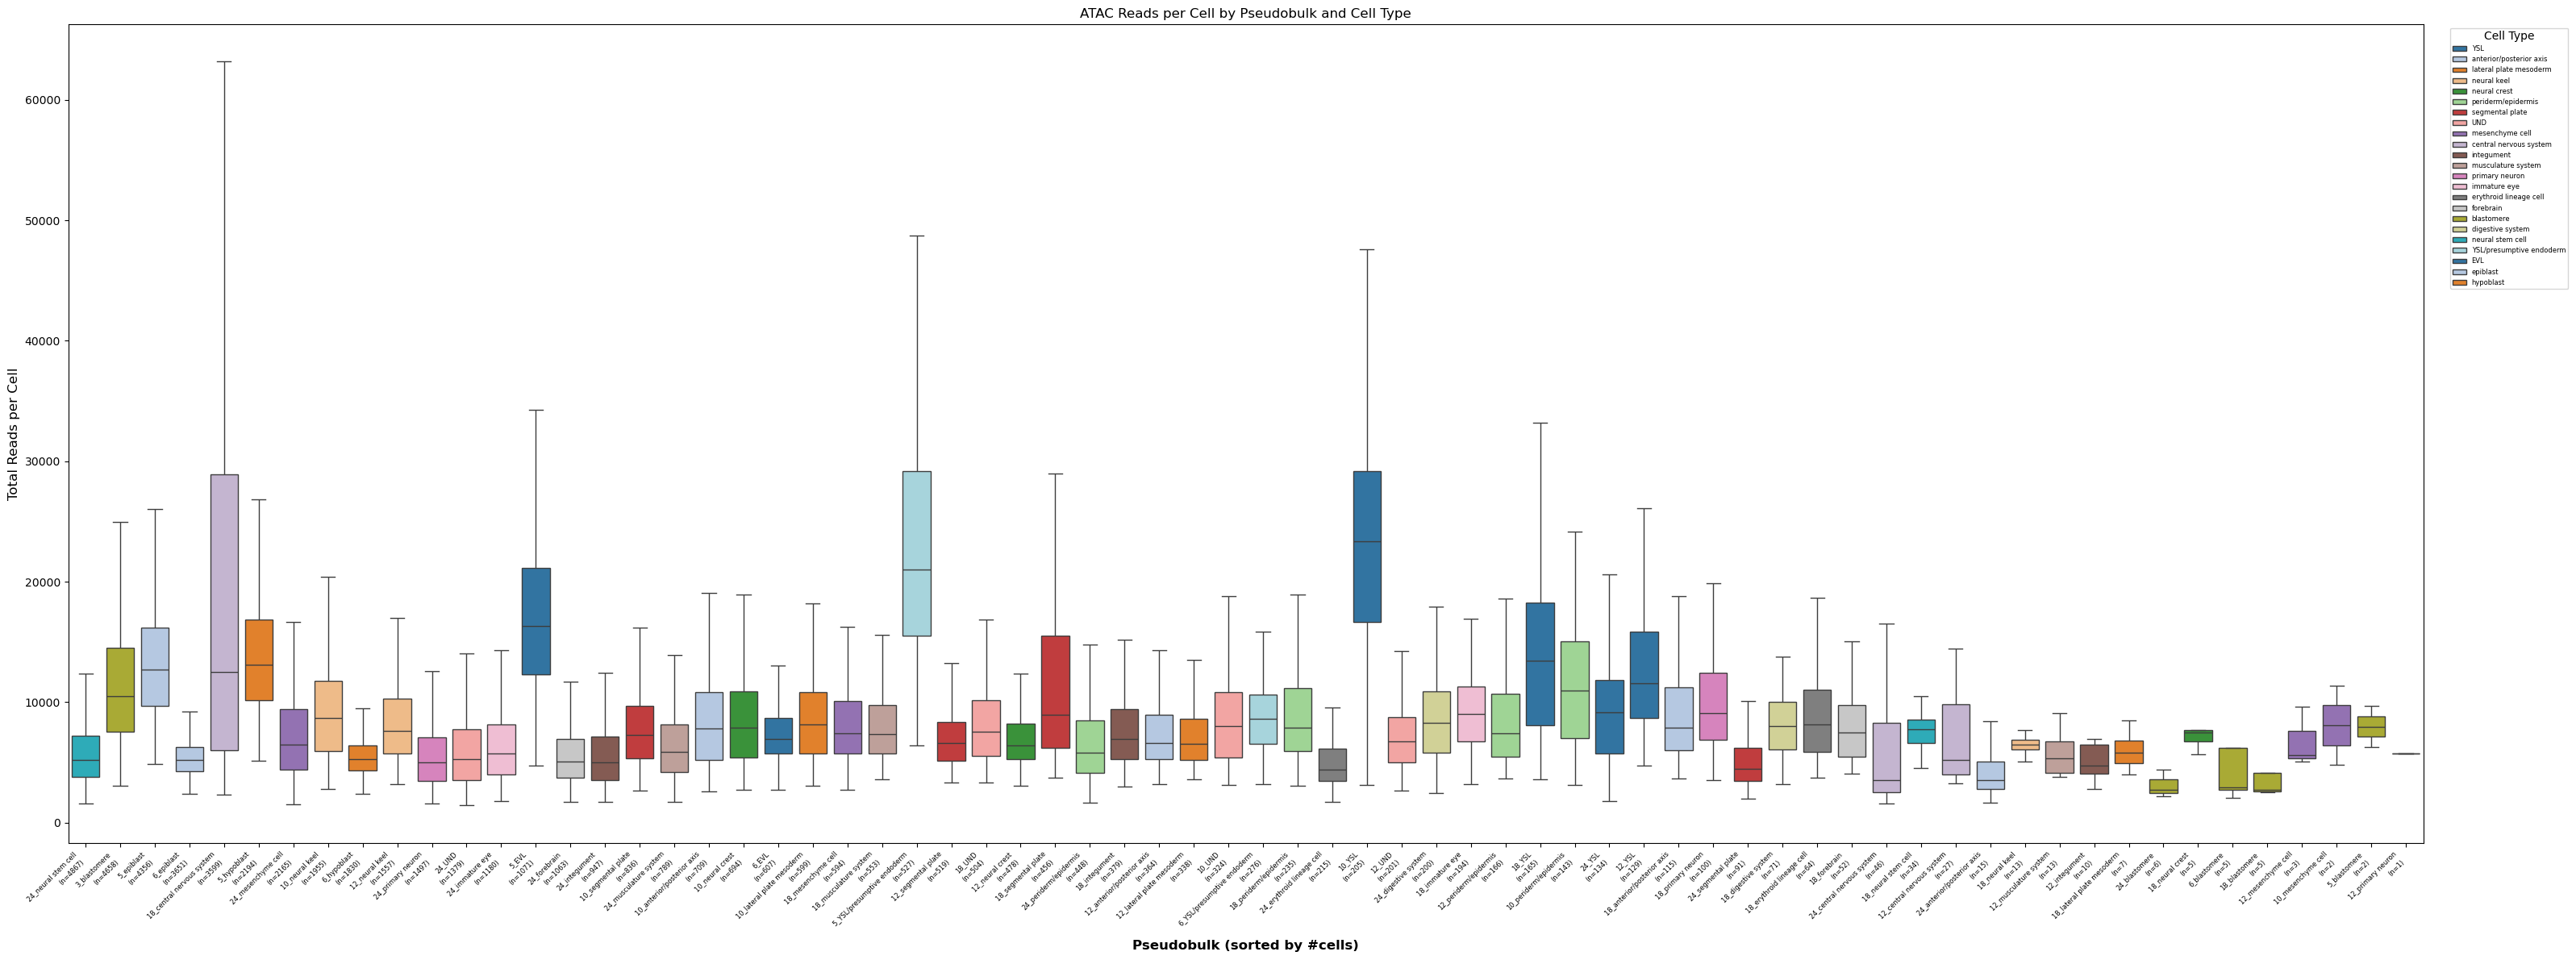

In [ ]:
plot_pseudobulk_cell_read_distributions(atac_data_df, atac_metadata_df, save_path=plot_dir, show = True)

Scatterplots: Pseudobulk Cell Read Statistics vs Number of Cells

1. Median Reads per Cell: The mean depth of cells in each pseudobulk.
2. Standard Deviation (Std): The variability in total reads per cell within each pseudobulk.
3. Max-Min Range: The total reads per cell range in each pseudobulk.

Assists pseudobulking quality control.

There seems no clear trend between the pseuodbulk size and the variability of reads per cell --> suggests that the variability within pseudobulk is not due to small sample size.  
In that case we would expect the variabiility (figure 2 & 3) to decrease as the sample size increases. Thus heterogeneity could either derive from biological signal or cell missclassification.


 ❓Could this indicate that the cause of heterogeneity in some pseudobulks is biological signal? If not, is it safe to discard heterogenious pseudobulks?



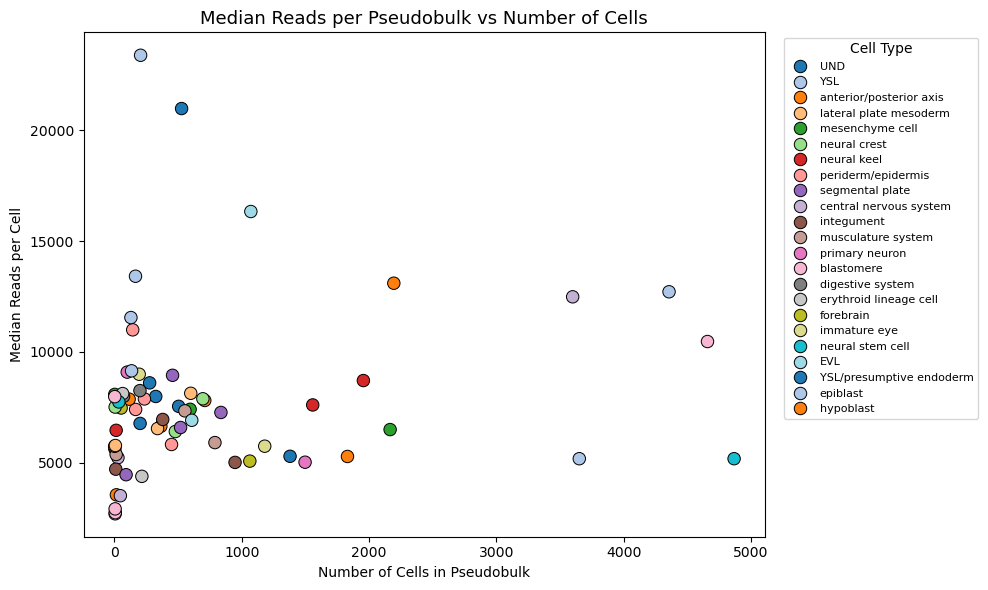

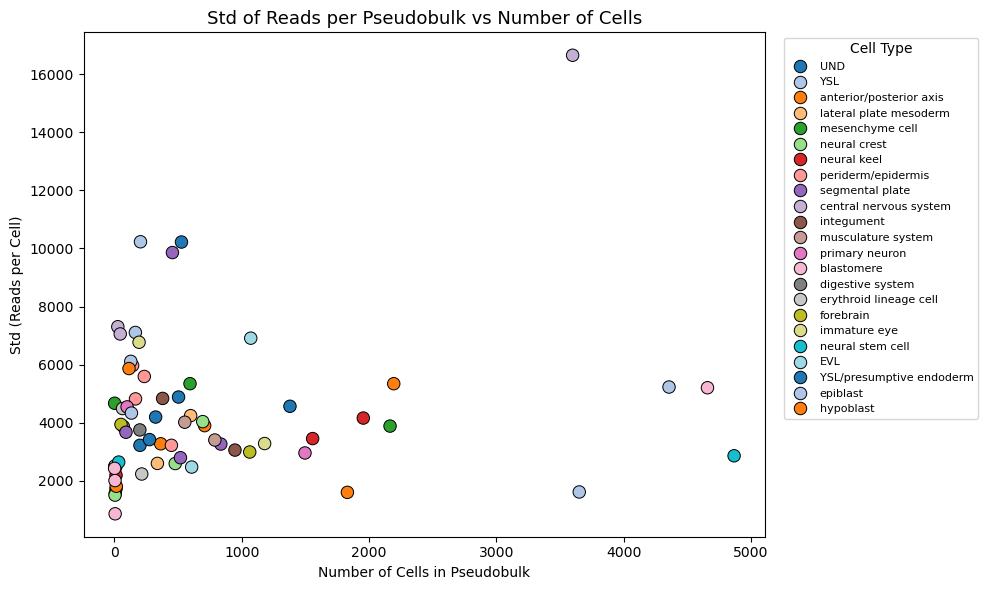

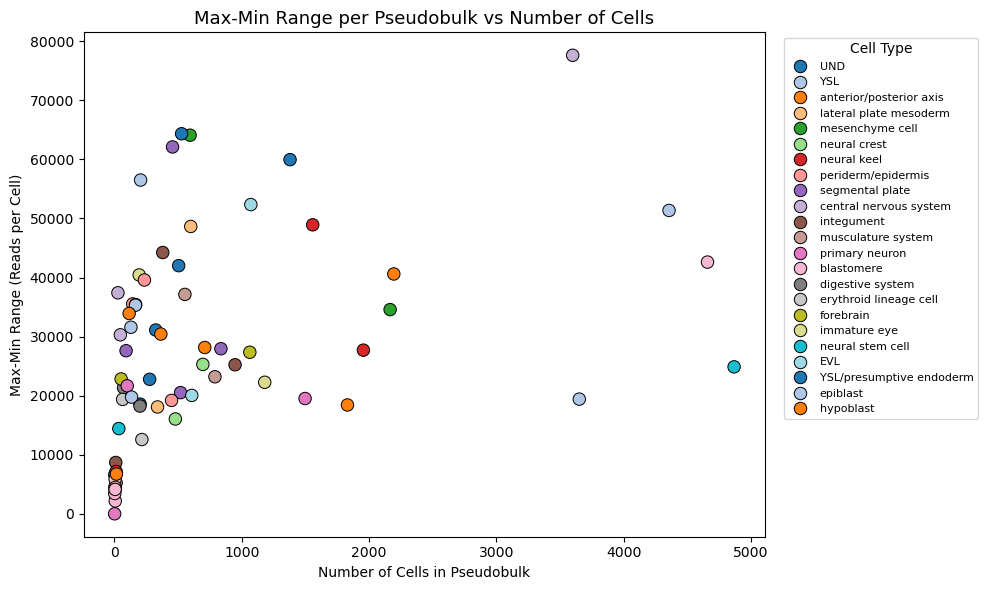

In [6]:
plot_pseudobulk_agg_stats(atac_data_df, atac_metadata_df, save_path=plot_dir, show=True)

### Plasticity check

Each boxplot shows, for a given cell type, how sequencing depth varies across developmental stages. 

* For most cell types, there is a general trend of decreasing total reads per cell as the developmental stage progresses.


Expectation:

* It is expected for earlier embryonic stages to be have a higher regulatory activity to facilitate normal cell differentiation. This could ezplain the decreasing depth trend through stages for a certain cell type.

❓ Does this make biological sense? Can this help us filter or confirm the quality of pseudobulks?

count    50637.000000
mean      9666.958963
std       7498.662092
min       1429.000000
25%       5098.000000
50%       7498.000000
75%      11699.000000
max      79956.000000
Name: Accessibility, dtype: float64


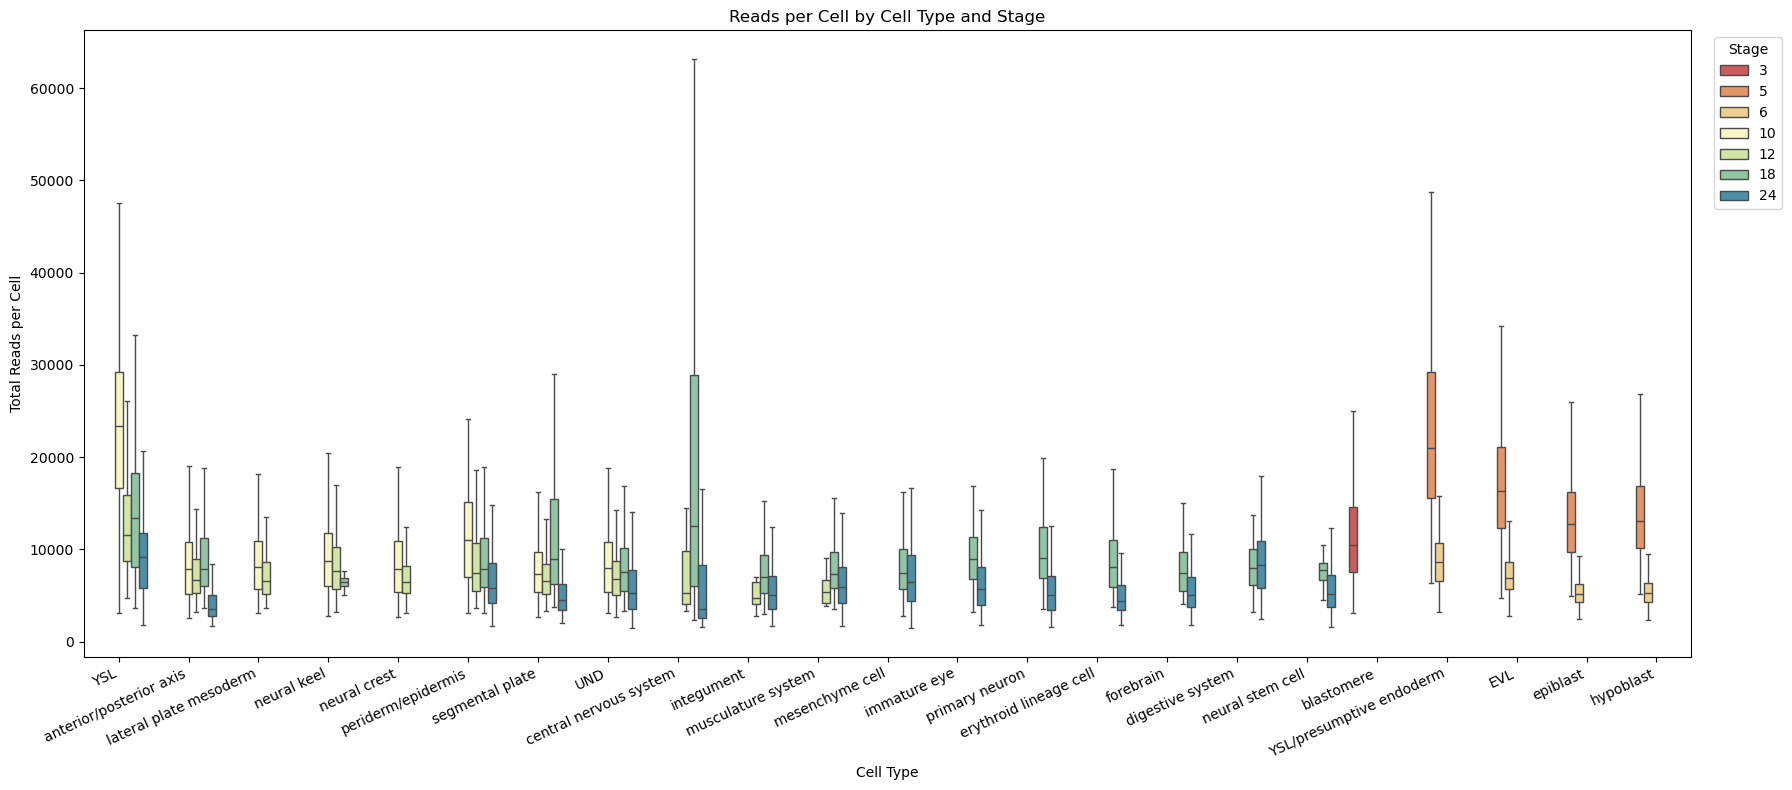

In [8]:
total_per_cell = atac_data_df.groupby('Cell')['Accessibility'].sum()
print(total_per_cell.describe())

plot_reads_per_cell_by_celltype_and_stage(
    total_per_cell,
    atac_metadata_df,
    min_cells_per_group=10,
    figsize=(18, 8),
    save_path = '../../data/embryo/plots/reads_per_cell_by_celltype_and_stage.png',
    show=True)

In [9]:

atac_data_cpm = cpm_normalize_sparse(atac_data_df)

pseudo_cpm = aggregate_atac_to_pseudobulk(atac_data_cpm, value_col='CPM')

In [ ]:
# cpm NO quantile normalization
cpm_raw = pseudo_cpm.copy()  # raw

cpm_log = pseudo_cpm.copy()  # log
cpm_log = np.log1p(pseudo_cpm)

# cpm QUANTILE normalization
cpm_Nolog_Qn = quantile_normalize(cpm_raw) # raw

cpm_log_Qn = quantile_normalize(cpm_log)   # log


In [21]:
cpm_nolog_qn = pd.DataFrame(
    cpm_log_Qn,
    columns=pseudo_cpm_nolog.columns,
    index=pseudo_cpm_nolog.index
)

cpm_log_qn = pd.DataFrame(
    cpm_log_Qn,
    columns=pseudo_cpm_log.columns,
    index=pseudo_cpm_log.index
)


Boxplot showing the CPM (cell's accessibility devided by the total number of reads and multiplied by 100) aggregated (by mean) dataset
* before and after logging the pseudobulks' accessibility values
* before and after quantile normalizing

x-axis: pseudobulks sorted by cell number in them

y-axis: accessibility values

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:246: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=6)


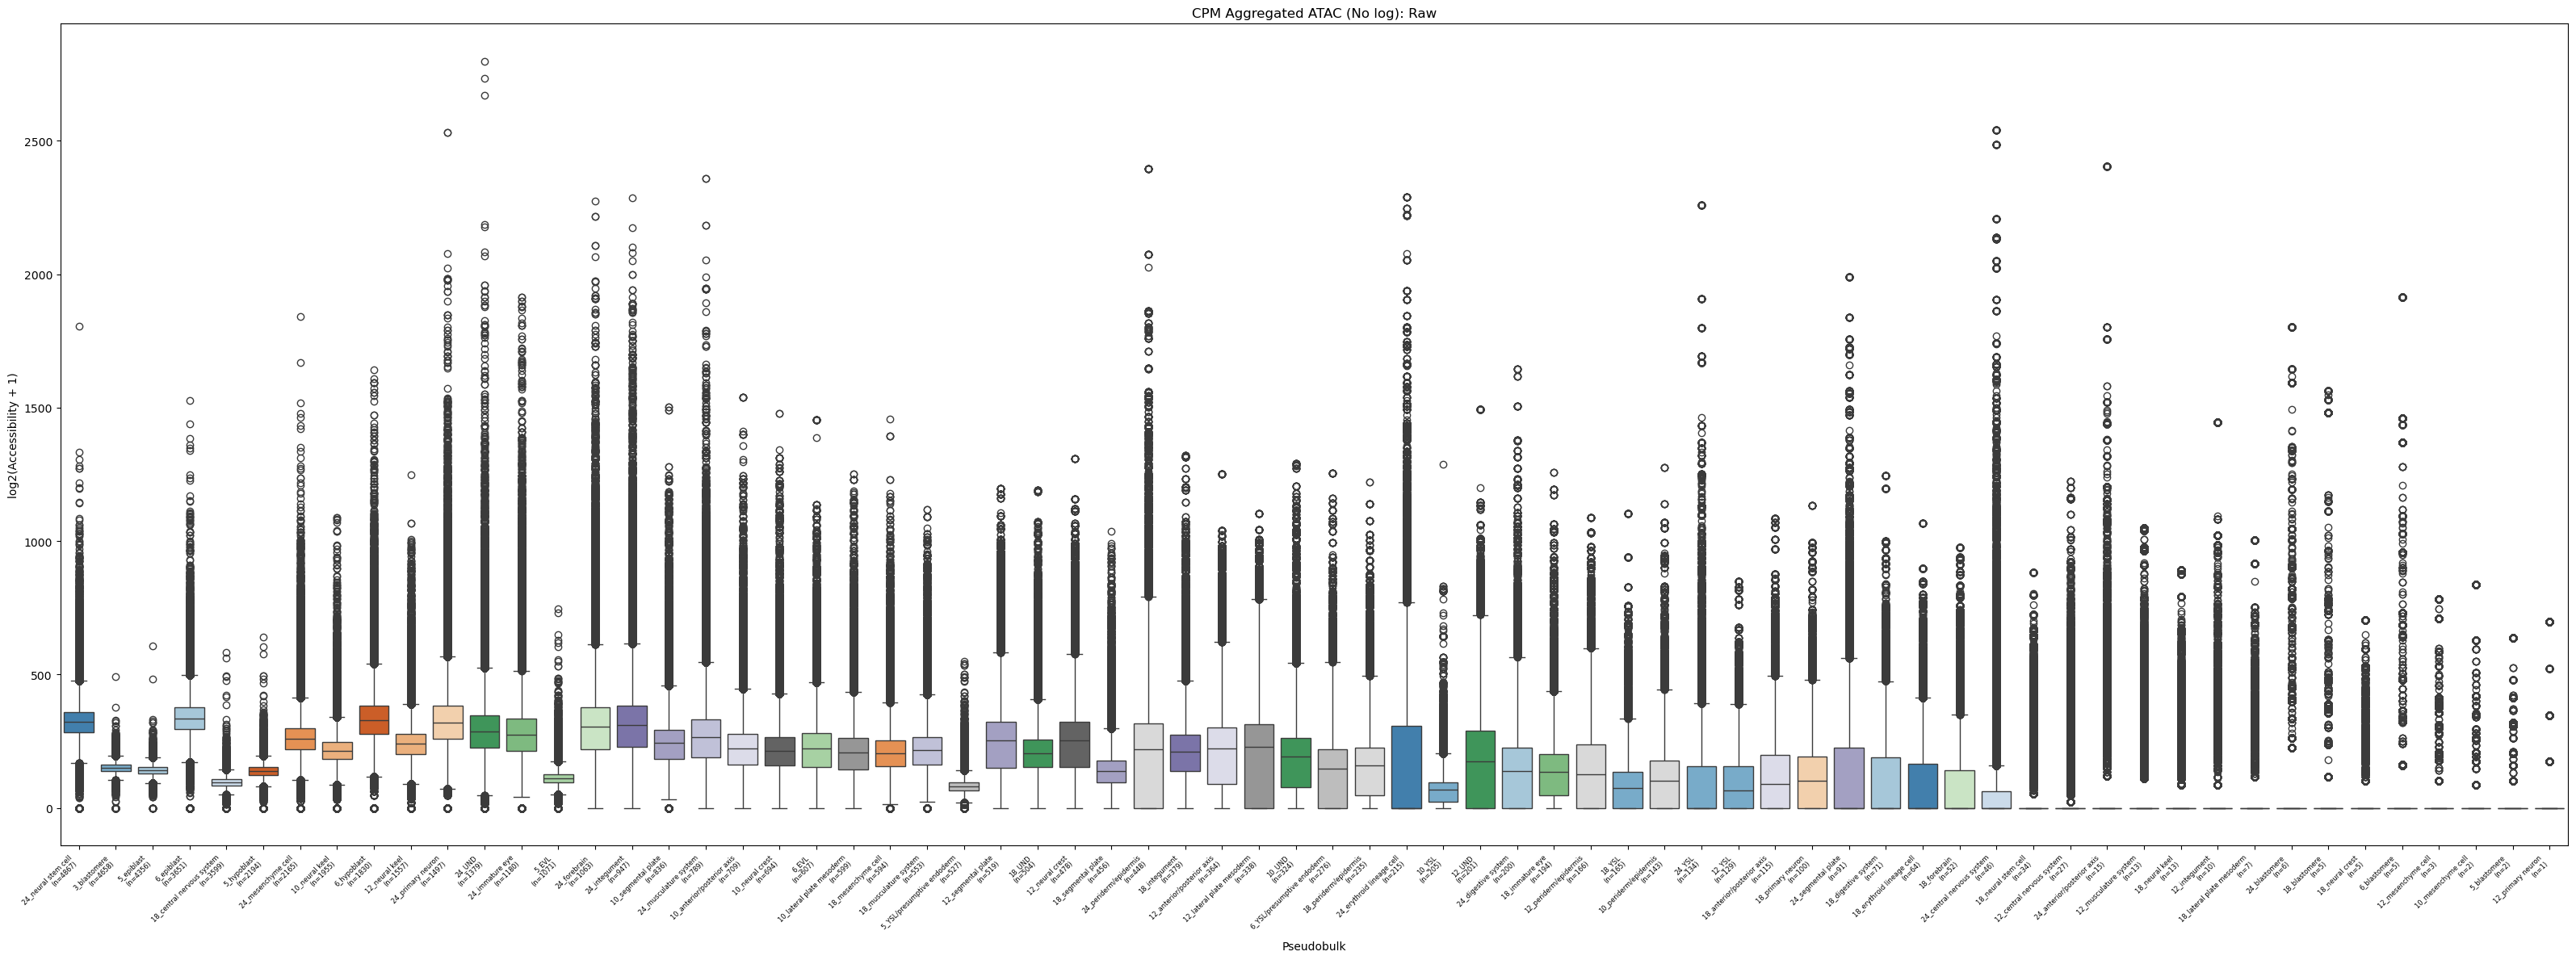

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:246: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=6)


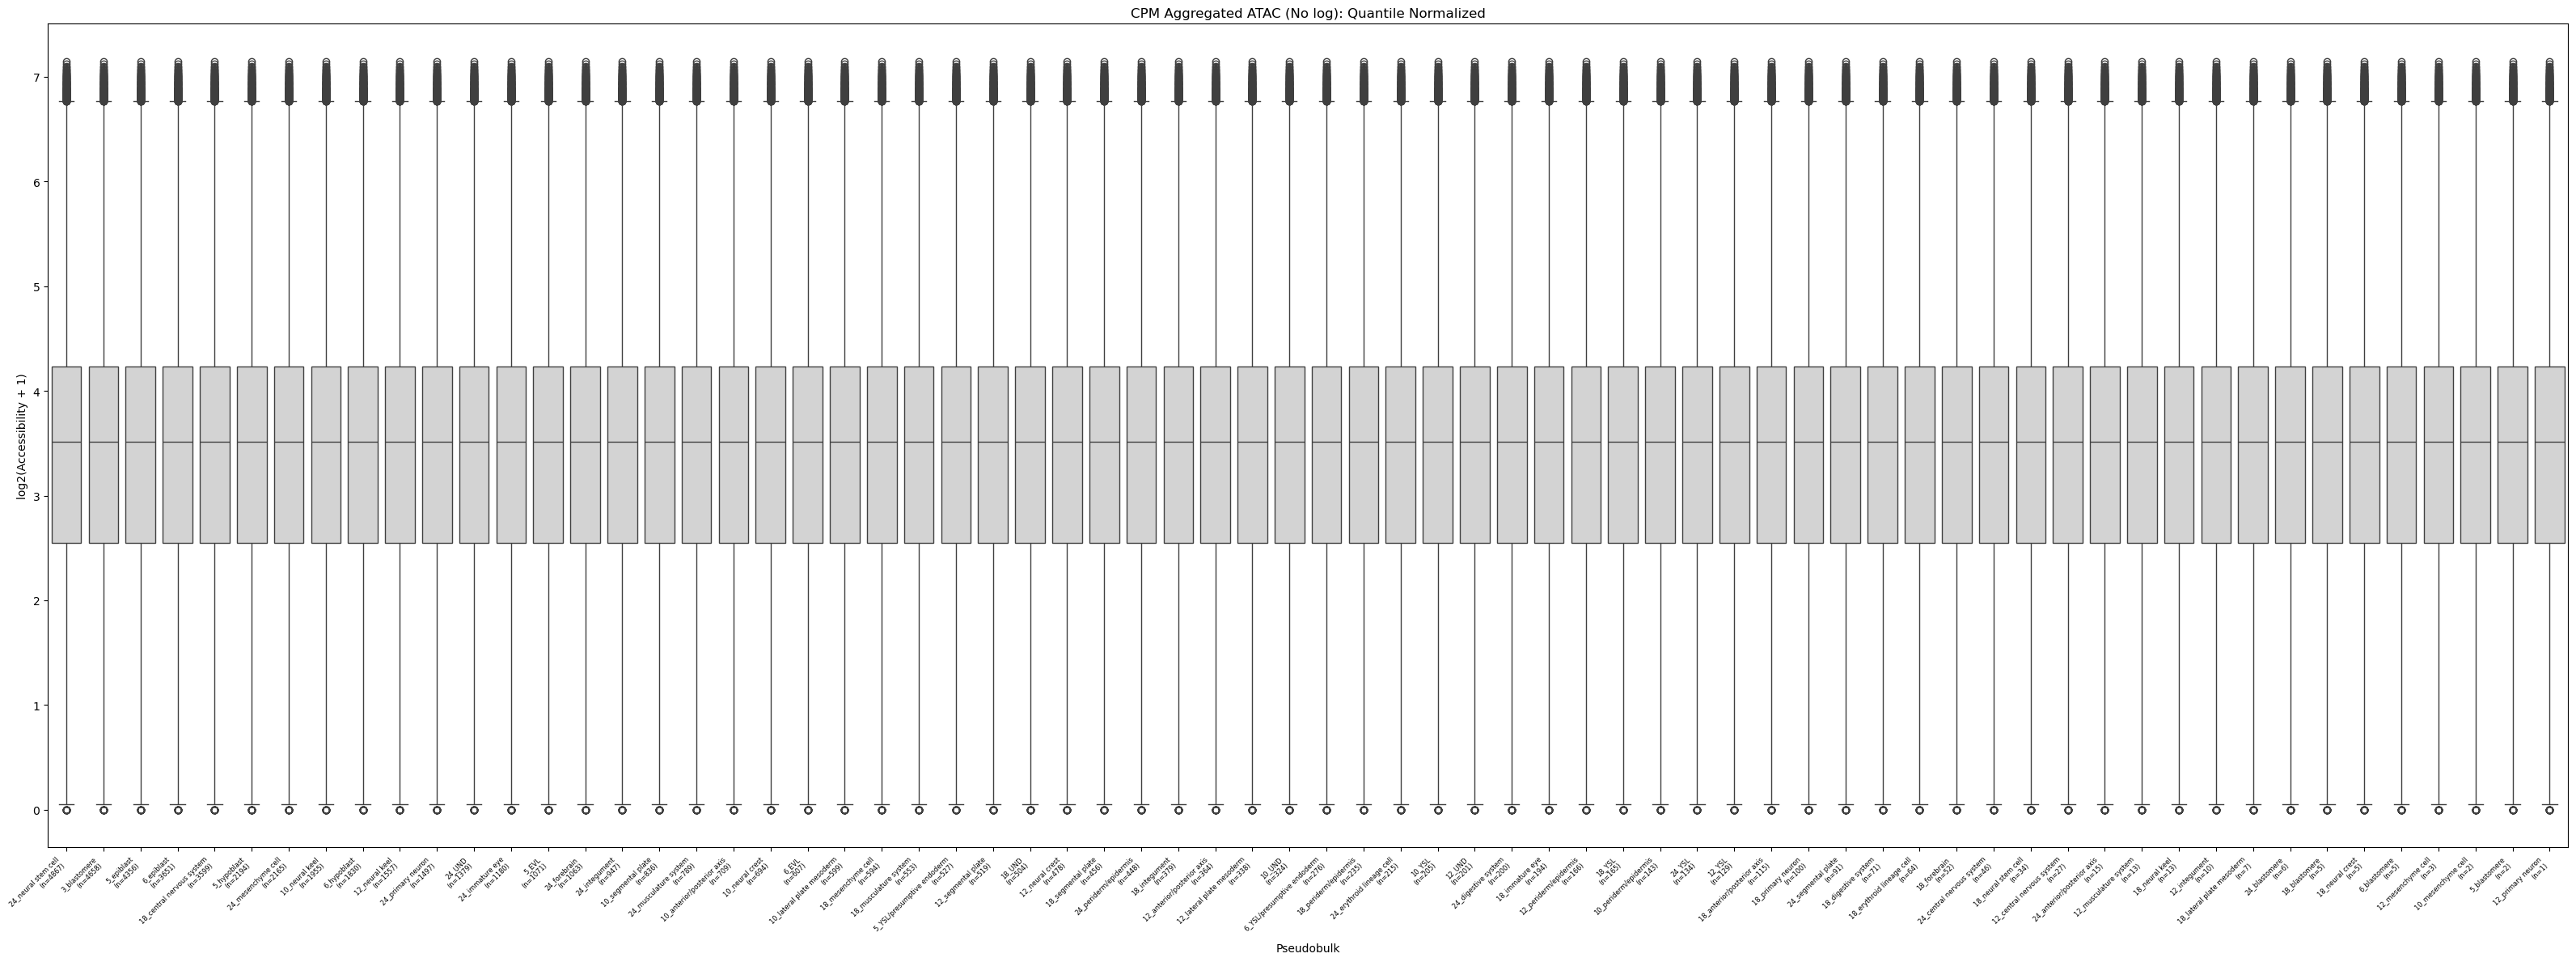

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:246: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=6)


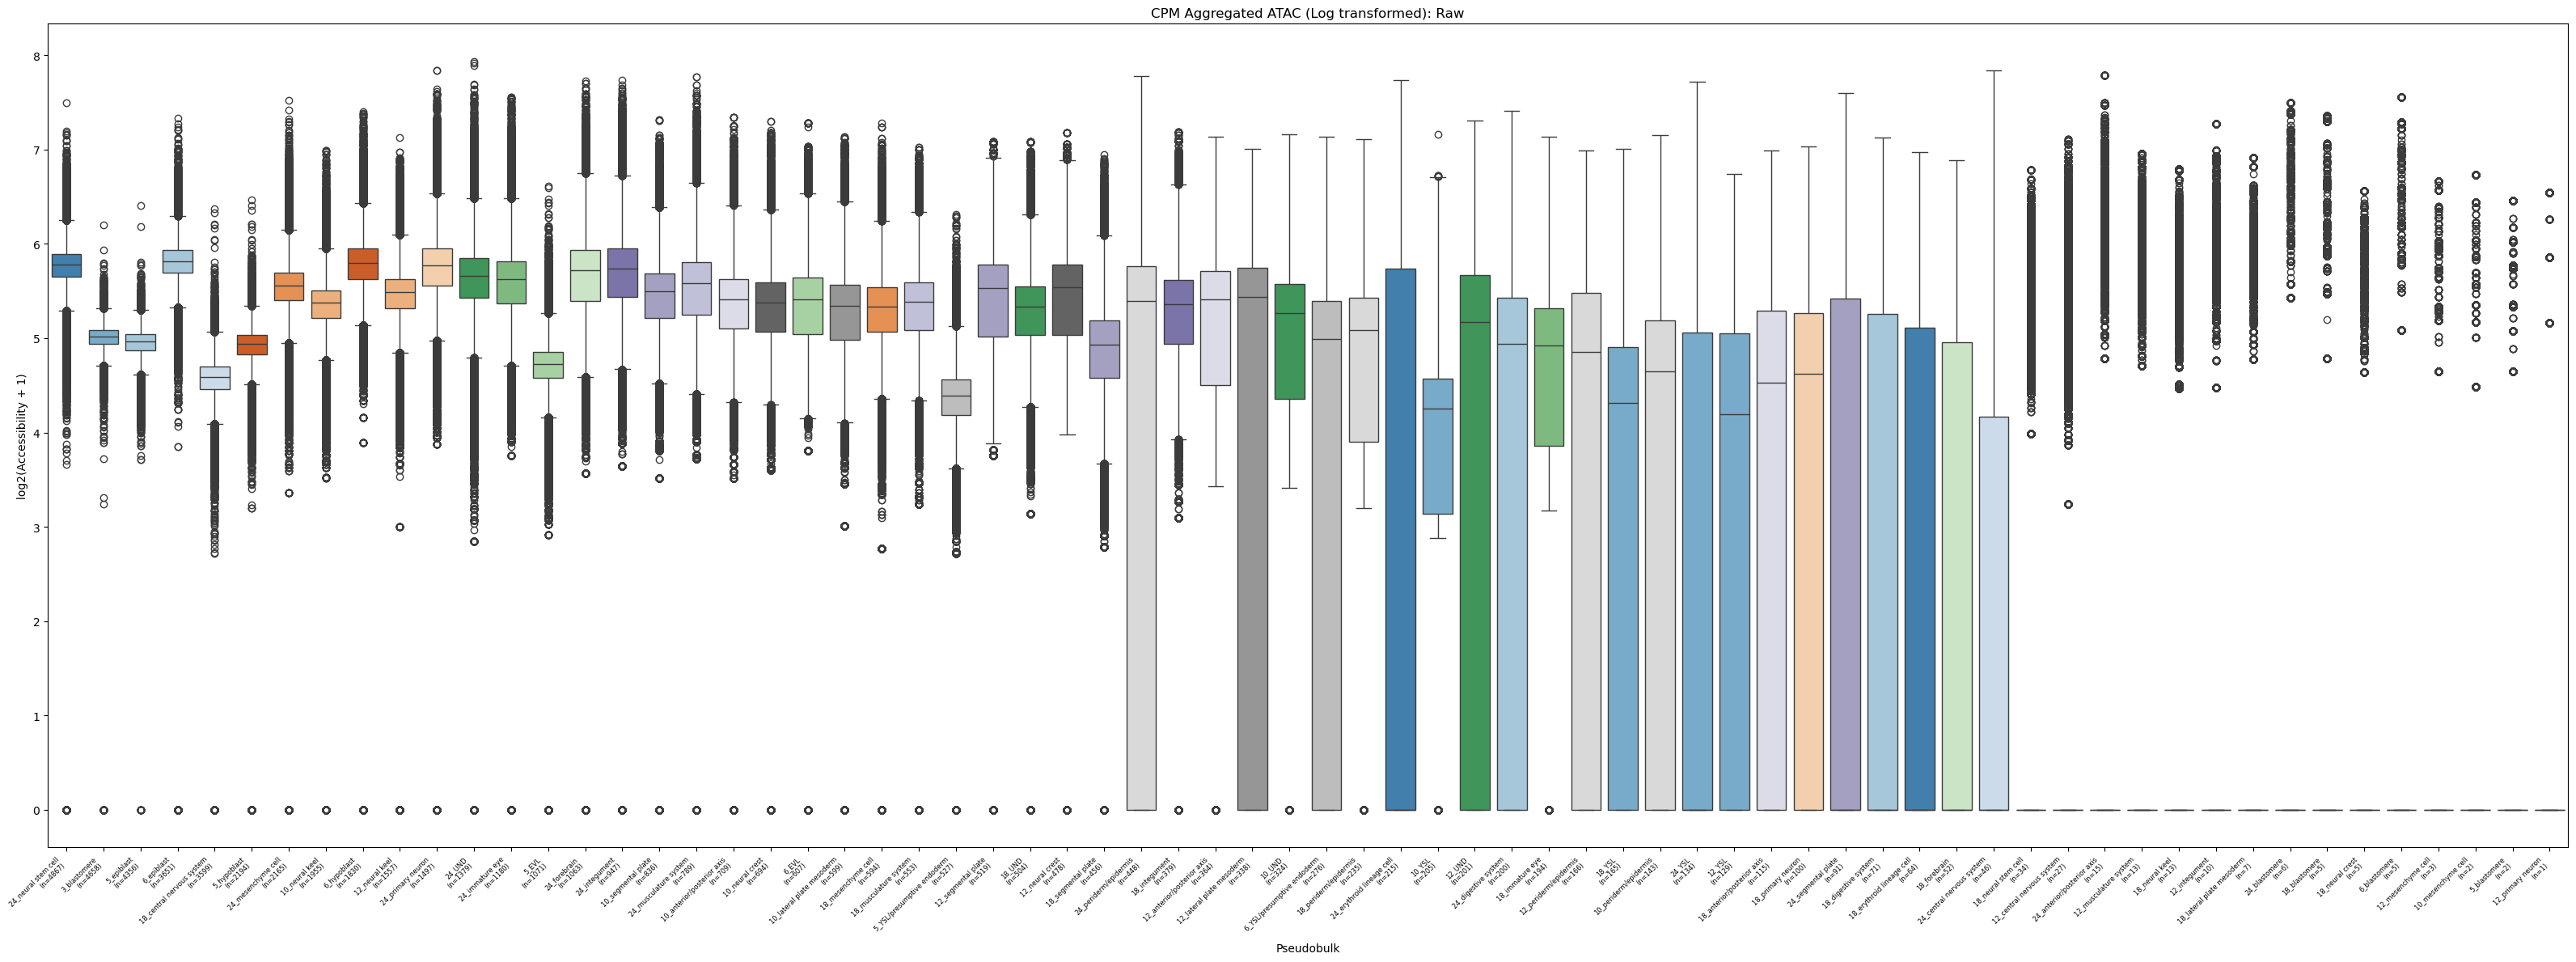

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:246: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=6)


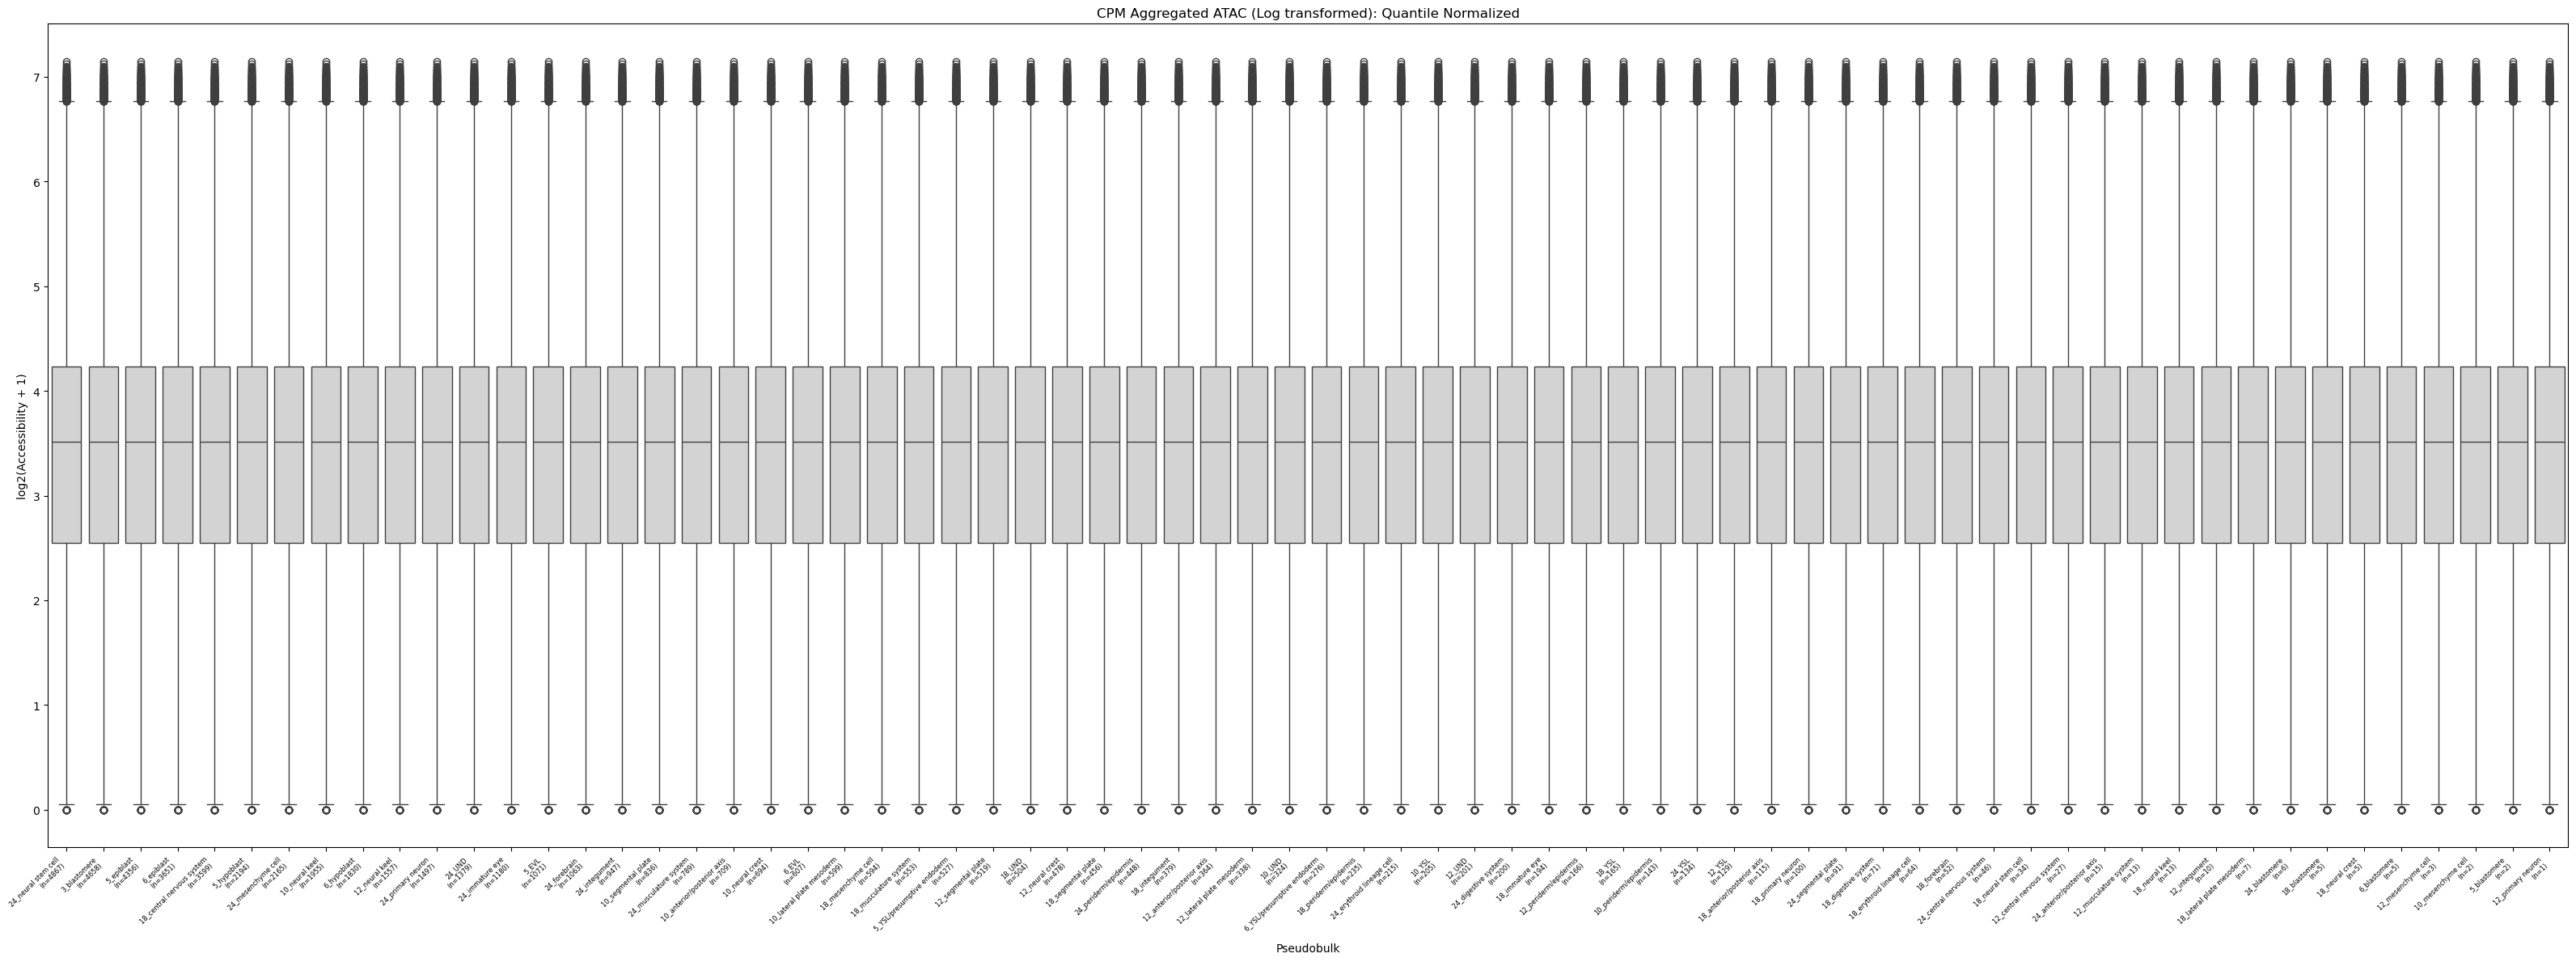

In [23]:
plot_dir = "../../data/embryo/plots"
pseudobulk_counts = atac_metadata_df['pseudobulk'].value_counts().to_dict()
plot_distributions(
    df_raw=cpm_nolog, 
    df_quant=cpm_Nolog_Qn, 
    title_prefix="CPM Aggregated ATAC (No log)",
    pseudobulk_counts=pseudobulk_counts,
)

plot_distributions(
    df_raw=cpm_log, 
    df_quant=cpm_Nolog_Qn, 
    title_prefix="CPM Aggregated ATAC (Log transformed)",
    pseudobulk_counts=pseudobulk_counts
)


#### Optionally filter pseudobulks with less than n cells (e.g. 100)

In [ ]:
# coordinate dataframe from atac_data_df
peak_coords = (
    atac_data_df[['Peak']]
    .drop_duplicates()
    .assign(
        chromosome=lambda df: df['Peak'].str.extract(r'(chr[\w]+)'),
        start=lambda df: df['Peak'].str.extract(r':(\d+)-')[0].astype(int),
        end=lambda df: df['Peak'].str.extract(r'-(\d+)')[0].astype(int)
    )
)
# Reset index to get 'Peak' as a column and merge coordinates
def attach_coords(matrix_df):
    return (
        matrix_df.reset_index()
        .merge(peak_coords, on='Peak', how='left')
        .dropna(subset=['chromosome', 'start', 'end'])
    )
attach_coords(cpm_nolog_qn)

In [29]:
attach_coords(cpm_nolog_qn).head()

,Peak,10_UND,10_YSL,10_anterior/posterior axis,10_lateral plate mesoderm,10_mesenchyme cell,10_neural crest,10_neural keel,10_periderm/epidermis,10_segmental plate,...,5_epiblast,5_hypoblast,6_EVL,6_YSL/presumptive endoderm,6_blastomere,6_epiblast,6_hypoblast,chromosome,start,end
0,chr10:10002124-10002624,4.517199,4.136115,2.934742,4.235681,2.846460,3.813445,3.511895,5.314109,5.139036,...,3.553658,6.474885,2.855224,3.452260,2.845113,4.339328,5.053746,chr10,10002124,10002624
1,chr10:10003707-10004207,2.827393,2.478875,4.424094,1.330676,3.996338,2.855775,3.884605,1.883948,3.891707,...,2.826841,4.784792,1.015522,2.204501,3.994541,0.872023,0.609591,chr10,10003707,10004207
2,chr10:10004747-10005247,4.219712,2.478387,3.563446,3.380321,3.996335,4.325492,4.516629,3.637527,2.827693,...,2.811080,2.220506,3.788177,2.822939,3.994538,1.645249,0.971994,chr10,10004747,10005247
3,chr10:10008047-10008547,4.133026,2.478390,4.134302,3.507416,3.996334,4.555838,3.913254,4.526872,4.456573,...,3.913195,3.636795,3.502574,3.913933,3.994535,4.322604,5.034261,chr10,10008047,10008547
4,chr10:10009662-10010162,2.186927,2.478394,3.520511,1.330678,3.996332,2.545397,1.175765,4.013578,6.745711,...,3.515561,2.030925,1.972088,1.673812,3.994531,2.035050,0.608867,chr10,10009662,10010162


In [ ]:
# Directory with FASTA files
fasta_dir = "../../data/genome"
save_dir = "../../data/embryo/processed"

# expanded length
expansion_length = 2000

# Apply to each version
df_nolog = attach_coords(cpm_nolog)
df_nolog_seq = extract_centered_sequences(df_nolog, fasta_dir, expansion_length, save_dir)

df_log = attach_coords(cpm_log)
df_log_seq = extract_centered_sequences(df_log, fasta_dir, expansion_length, save_dir)

df_nolog_qn = attach_coords(cpm_Nolog_Qn)
df_nolog_qn_seq = extract_centered_sequences(df_nolog_qn, fasta_dir, expansion_length, save_dir)

df_log_qn = attach_coords(cpm_log_Qn)
df_log_qn_seq = extract_centered_sequences(df_log_qn, fasta_dir, expansion_length, save_dir)


In [38]:
df_log_qn_seq

,Peak,10_UND,10_YSL,10_anterior/posterior axis,10_lateral plate mesoderm,10_mesenchyme cell,10_neural crest,10_neural keel,10_periderm/epidermis,10_segmental plate,...,5_hypoblast,6_EVL,6_YSL/presumptive endoderm,6_blastomere,6_epiblast,6_hypoblast,chromosome,start,end,sequence
0,chr10:10002124-10002624,4.517199,4.136115,2.934742,4.235681,2.846460,3.813445,3.511895,5.314109,5.139036,...,6.474885,2.855224,3.452260,2.845113,4.339328,5.053746,10,10002124,10002624,TGCTTTCTCATGCAGCAAACACGTGTGCATAATAAGACATTTTGTG...
1,chr10:10003707-10004207,2.827393,2.478875,4.424094,1.330676,3.996338,2.855775,3.884605,1.883948,3.891707,...,4.784792,1.015522,2.204501,3.994541,0.872023,0.609591,10,10003707,10004207,TAGCTTTTAACAATAAAATAAACAAACAAACAAACAATTACAATAA...
2,chr10:10004747-10005247,4.219712,2.478387,3.563446,3.380321,3.996335,4.325492,4.516629,3.637527,2.827693,...,2.220506,3.788177,2.822939,3.994538,1.645249,0.971994,10,10004747,10005247,TTTCTGCTCATAGCTGGATCCATTTCCGCTGCTCCTGTCGCCACAT...
3,chr10:10008047-10008547,4.133026,2.478390,4.134302,3.507416,3.996334,4.555838,3.913254,4.526872,4.456573,...,3.636795,3.502574,3.913933,3.994535,4.322604,5.034261,10,10008047,10008547,ATCTCTAATAAAGCTGTGGTACTTAAATAAAGCTCAGTTGGAATTA...
4,chr10:10009662-10010162,2.186927,2.478394,3.520511,1.330678,3.996332,2.545397,1.175765,4.013578,6.745711,...,2.030925,1.972088,1.673812,3.994531,2.035050,0.608867,10,10009662,10010162,CTAACATTTGAGCGCTATTGAGCACAGTCTTAAACAGCGCTGGTTT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370053,chr9:998557-999057,2.186743,2.544945,2.218797,2.026449,2.846487,2.211627,5.918924,1.883960,5.273318,...,2.655222,4.533221,3.469131,2.845131,4.359985,4.558710,9,998557,999057,ATATTTCTTGTAAAGGAAATAATAGATTTAGTAACTATGTAAAGTA...
370054,chr9:9989556-9990056,3.486961,4.214787,3.968464,6.336509,2.846481,2.397210,4.208787,4.320484,2.843659,...,3.972664,3.773550,4.576358,2.845128,0.876456,2.041547,9,9989556,9990056,GTTTTGGCTTCTTGGTGGCCATTCCTCCAATCATGACCATGTTAGG...
370055,chr9:9992990-9993490,2.554609,2.825087,1.976085,2.839289,2.846478,0.958677,2.179356,3.012429,1.249822,...,2.112190,2.042434,1.673667,2.845126,3.147305,4.512664,9,9992990,9993490,TGAGAGATATTCTGCAGCAATGACTCCGACAGTCTCAAATGGATCC...
370056,chr9:9997607-9998107,3.773550,4.559259,2.479997,2.014287,2.846472,0.958617,3.522557,5.040542,2.856814,...,2.013201,2.866211,5.223467,2.845121,4.237000,2.202072,9,9997607,9998107,TACCCCTGTACGCAGAACCCAAAATAACTGGTTCATAGAGTTTTGT...


In [59]:
import pandas as pd
from scipy.spatial import cKDTree
import numpy as np

def extract_tss_from_gtf(gtf_path):
    colnames = [
        "chrom", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"
    ]
    gtf = pd.read_csv(
        gtf_path, sep='\t', comment='#', names=colnames, low_memory=False
    )

    # Keep only transcripts or exons to get TSS
    gtf = gtf[gtf['feature'] == 'transcript']

    # Compute TSS depending on strand
    gtf['TSS'] = gtf.apply(lambda row: row['start'] if row['strand'] == '+' else row['end'], axis=1)
    gtf = gtf[['chrom', 'TSS', 'strand', 'attribute']].copy()

    return gtf
gtf_path = "../../data/genome/Danio_rerio.GRCz11.111.chr.gtf"

tss_df = extract_tss_from_gtf(gtf_path)



In [64]:
tss_df

,chrom,TSS,strand,attribute
1,4,30402837,+,"gene_id ""ENSDARG00000103202""; gene_version ""2""..."
6,4,1722899,+,"gene_id ""ENSDARG00000009657""; gene_version ""8""..."
23,4,1722903,+,"gene_id ""ENSDARG00000009657""; gene_version ""8""..."
27,4,40758511,+,"gene_id ""ENSDARG00000096472""; gene_version ""2""..."
31,4,11106856,-,"gene_id ""ENSDARG00000096156""; gene_version ""3""..."
...,...,...,...,...
1153765,MT,15232,-,"gene_id ""ENSDARG00000063922""; gene_version ""3""..."
1153771,MT,15301,-,"gene_id ""ENSDARG00000083312""; gene_version ""3""..."
1153774,MT,15308,+,"gene_id ""ENSDARG00000063924""; gene_version ""3""..."
1153779,MT,16449,+,"gene_id ""ENSDARG00000083462""; gene_version ""3""..."


In [70]:
from scipy.spatial import cKDTree
import numpy as np

def fix_chromosome_types(peaks_df, tss_df):
    peaks_fixed = peaks_df.copy()
    tss_fixed = tss_df.copy()
    
    peaks_fixed['chromosome'] = peaks_fixed['chromosome'].astype(str)
    tss_fixed['chrom'] = tss_fixed['chrom'].astype(str)
    
    return peaks_fixed, tss_fixed

def annotate_promoter_enhancer(peaks_df, tss_df, distance_threshold=1000):
    peaks_df, tss_df = fix_chromosome_types(peaks_df, tss_df)
    
    annotations = []
    
    for chrom in peaks_df['chromosome'].unique():
        peaks_chr = peaks_df[peaks_df['chromosome'] == chrom]
        tss_chr = tss_df[tss_df['chrom'] == chrom]
        
        if len(tss_chr) == 0:
            annotations.extend(["enhancer"] * len(peaks_chr))
            continue
        
        peak_centers = ((peaks_chr['start'] + peaks_chr['end']) // 2).values.reshape(-1, 1)
        tss_positions = tss_chr['TSS'].values.reshape(-1, 1)
        
        tree = cKDTree(tss_positions)
        distances, _ = tree.query(peak_centers, k=1)
        
        labels = np.where(distances <= distance_threshold, 'promoter', 'enhancer')
        annotations.extend(labels.tolist())
    
    # Add annotations to DataFrame
    result_df = peaks_df.copy()
    result_df['region_type'] = annotations
    
    return result_df

In [71]:
# Annotate your peaks
df_annotated = annotate_promoter_enhancer(df_log_qn_seq, tss_df, distance_threshold=1000)

# Check results
print(f"Promoters: {(df_annotated['region_type'] == 'promoter').sum()}")
print(f"Enhancers: {(df_annotated['region_type'] == 'enhancer').sum()}")

Promoters: 44711
Enhancers: 325347


Found 44711 promoter peaks and 325347 enhancer peaks
Matching peaks in data: 0 promoters, 0 enhancers
Keeping 0 pseudobulk groups with >= 10 cells

Summary Statistics:
Empty DataFrame
Columns: [mean, median]
Index: []


/tmp/ipykernel_1475154/2814737766.py:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Region Type', bbox_to_anchor=(1.01, 1), loc='upper left')


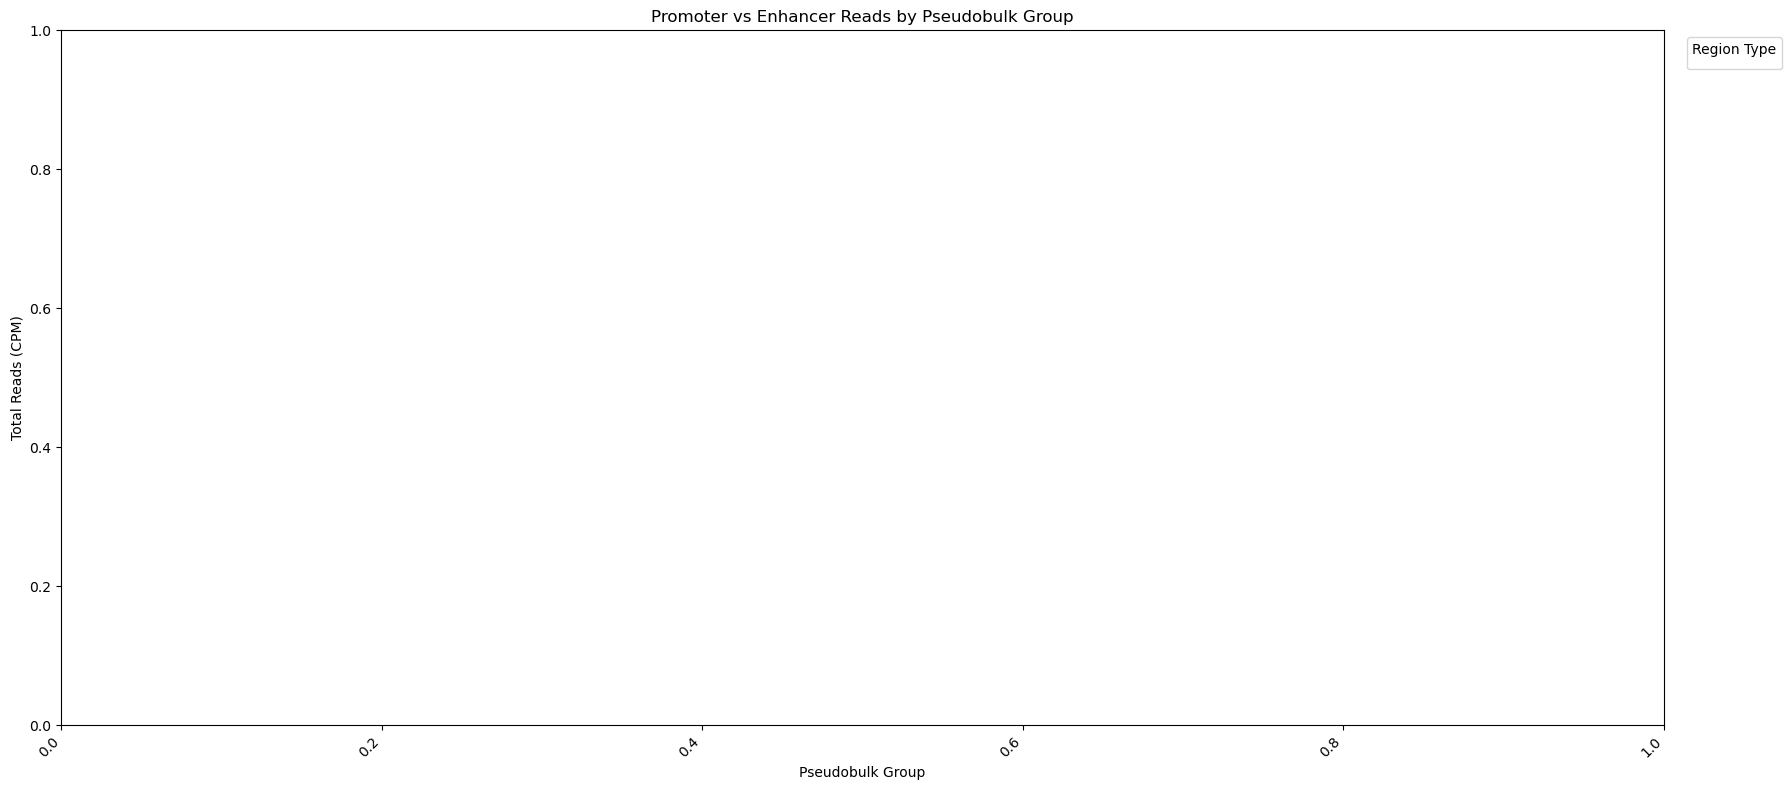

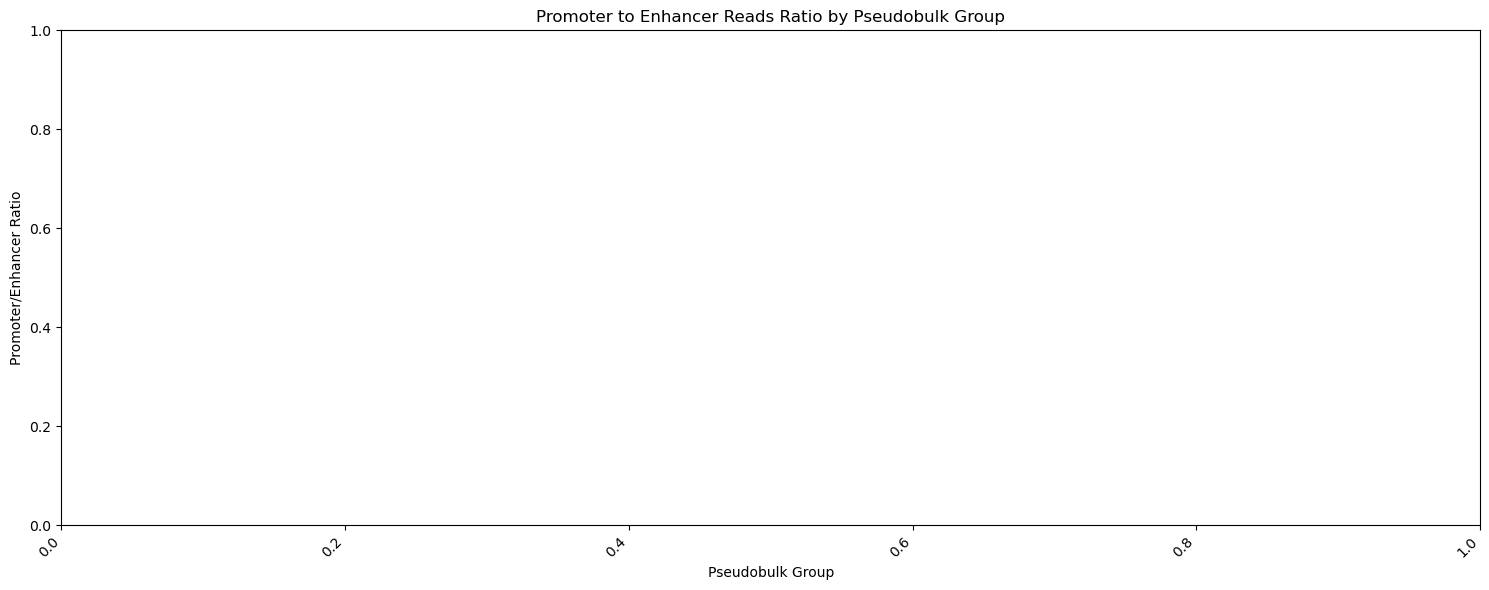

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_promoter_enhancer_reads_by_pseudobulk(
    atac_data_cpm,
    atac_metadata_df,
    df_annotated,  # Your annotated peaks with 'region_type' column
    min_cells_per_group=10,
    figsize=(18, 8),
    save_path=None,
    show=True
):
    """
    Plot total promoter vs enhancer reads by pseudobulk group.
    
    Parameters:
    - atac_data_cpm: DataFrame with Peak as index and cells as columns, CPM values
    - atac_metadata_df: DataFrame with cell metadata including 'pseudobulk' column
    - df_annotated: DataFrame with peak annotations including 'region_type' column
    - min_cells_per_group: Minimum cells required per pseudobulk group
    - figsize: Figure size tuple
    - save_path: Path to save figure (optional)
    - show: Whether to display the plot
    """
    
    # Get promoter and enhancer peak lists
    promoter_peaks = df_annotated[df_annotated['region_type'] == 'promoter']['Peak'].tolist()
    enhancer_peaks = df_annotated[df_annotated['region_type'] == 'enhancer']['Peak'].tolist()
    
    print(f"Found {len(promoter_peaks)} promoter peaks and {len(enhancer_peaks)} enhancer peaks")
    
    # Filter peaks that exist in atac_data_cpm
    promoter_peaks = [p for p in promoter_peaks if p in atac_data_cpm.index]
    enhancer_peaks = [p for p in enhancer_peaks if p in atac_data_cpm.index]
    
    print(f"Matching peaks in data: {len(promoter_peaks)} promoters, {len(enhancer_peaks)} enhancers")
    
    # Calculate total reads per cell for promoters and enhancers
    promoter_reads_per_cell = atac_data_cpm.loc[promoter_peaks].sum(axis=0)
    enhancer_reads_per_cell = atac_data_cpm.loc[enhancer_peaks].sum(axis=0)
    
    # Create combined dataframe
    reads_df = pd.DataFrame({
        'Cell': promoter_reads_per_cell.index,
        'Promoter_Reads': promoter_reads_per_cell.values,
        'Enhancer_Reads': enhancer_reads_per_cell.values
    })
    
    # Merge with metadata
    df_reads = reads_df.merge(
        atac_metadata_df[['atac_cell', 'pseudobulk']], 
        left_on='Cell', 
        right_on='atac_cell', 
        how='left'
    ).dropna(subset=['pseudobulk'])
    
    # Filter to groups with enough cells
    pseudobulk_counts = df_reads.groupby('pseudobulk').size().reset_index(name='count')
    good_groups = pseudobulk_counts[pseudobulk_counts['count'] >= min_cells_per_group]['pseudobulk'].tolist()
    df_reads = df_reads[df_reads['pseudobulk'].isin(good_groups)]
    
    print(f"Keeping {len(good_groups)} pseudobulk groups with >= {min_cells_per_group} cells")
    
    # Reshape data for plotting (melt to long format)
    df_plot = pd.melt(
        df_reads,
        id_vars=['Cell', 'pseudobulk'],
        value_vars=['Promoter_Reads', 'Enhancer_Reads'],
        var_name='Region_Type',
        value_name='Total_Reads'
    )
    
    # Clean up region type names
    df_plot['Region_Type'] = df_plot['Region_Type'].str.replace('_Reads', '')
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Create box plot
    sns.boxplot(
        data=df_plot,
        x='pseudobulk',
        y='Total_Reads',
        hue='Region_Type',
        showfliers=False,
        palette=['#e74c3c', '#3498db']  # Red for promoter, blue for enhancer
    )
    
    plt.xlabel('Pseudobulk Group')
    plt.ylabel('Total Reads (CPM)')
    plt.title('Promoter vs Enhancer Reads by Pseudobulk Group')
    plt.legend(title='Region Type', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Print summary statistics
    summary_stats = df_plot.groupby(['pseudobulk', 'Region_Type'])['Total_Reads'].agg(['mean', 'median']).round(2)
    print("\nSummary Statistics:")
    print(summary_stats)
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()
        
    return df_plot

def plot_promoter_enhancer_ratio_by_pseudobulk(
    atac_data_cpm,
    atac_metadata_df,
    df_annotated,
    min_cells_per_group=10,
    figsize=(15, 6),
    save_path=None,
    show=True
):
    """
    Plot promoter/enhancer ratio by pseudobulk group.
    """
    # Get the data (reuse logic from main function)
    promoter_peaks = df_annotated[df_annotated['region_type'] == 'promoter']['Peak'].tolist()
    enhancer_peaks = df_annotated[df_annotated['region_type'] == 'enhancer']['Peak'].tolist()
    
    promoter_peaks = [p for p in promoter_peaks if p in atac_data_cpm.index]
    enhancer_peaks = [p for p in enhancer_peaks if p in atac_data_cpm.index]
    
    promoter_reads_per_cell = atac_data_cpm.loc[promoter_peaks].sum(axis=0)
    enhancer_reads_per_cell = atac_data_cpm.loc[enhancer_peaks].sum(axis=0)
    
    reads_df = pd.DataFrame({
        'Cell': promoter_reads_per_cell.index,
        'Promoter_Reads': promoter_reads_per_cell.values,
        'Enhancer_Reads': enhancer_reads_per_cell.values
    })
    
    df_reads = reads_df.merge(
        atac_metadata_df[['atac_cell', 'pseudobulk']], 
        left_on='Cell', 
        right_on='atac_cell', 
        how='left'
    ).dropna(subset=['pseudobulk'])
    
    # Filter groups
    pseudobulk_counts = df_reads.groupby('pseudobulk').size().reset_index(name='count')
    good_groups = pseudobulk_counts[pseudobulk_counts['count'] >= min_cells_per_group]['pseudobulk'].tolist()
    df_reads = df_reads[df_reads['pseudobulk'].isin(good_groups)]
    
    # Calculate ratio (avoid division by zero)
    df_reads['Promoter_Enhancer_Ratio'] = df_reads['Promoter_Reads'] / (df_reads['Enhancer_Reads'] + 1e-6)
    
    plt.figure(figsize=figsize)
    sns.boxplot(
        data=df_reads,
        x='pseudobulk',
        y='Promoter_Enhancer_Ratio',
        showfliers=False,
        color='#9b59b6'
    )
    
    plt.xlabel('Pseudobulk Group')
    plt.ylabel('Promoter/Enhancer Ratio')
    plt.title('Promoter to Enhancer Reads Ratio by Pseudobulk Group')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()

# Usage example:
df_plot = plot_promoter_enhancer_reads_by_pseudobulk(
    atac_data_df, 
    atac_metadata_df, 
    df_annotated,  # Your annotated peaks with region_type column
    min_cells_per_group=10
)

# Optional: Plot ratio as well
plot_promoter_enhancer_ratio_by_pseudobulk(
    atac_data_df, 
    atac_metadata_df, 
    df_annotated
)